# Tutorial: How to use Qutip for Spin systems

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as q 

## Time independant solutions

qutip is a library with many pre programmed tools to directly apply to your system. In the following we want to directly apply it to the Hamiltonian for a single spin system.

$H = \omega_s S_z + \Omega_1 \cos(\omega t) S_x$

This Hamiltonian can be easily solved with rotating wave approximation ($\omega_s = \omega + \Delta$) to:

$H = \Delta S_z + \frac{\Omega_1}{2} S_x$

### Rabi Oscillations Spin 1/2

Text(0.5, 0, 'time')

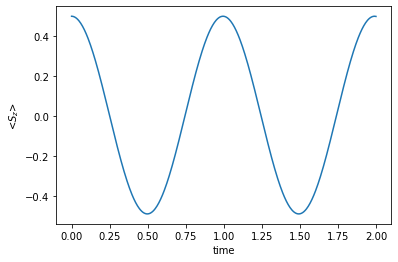

In [92]:
#Define the operators 1/2
sz = q.sigmaz() * 0.5
sx = q.sigmax() * 0.5
sy = q.sigmay() * 0.5


#Physical frequencies
Omega = 1
Omega *= 2 * np.pi
Delta = 0.1 * 2 * np.pi

# NV hamiltonian
H0 = Delta * sz + Omega * sx 


#simulation parameters
time_x=2
npoints = 500
t = np.linspace(0, time_x, npoints)

#initial state - rho
a = 0
phi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)
rho_nv = phi*phi.dag()

#solve evolution
resultat = []
resultat.append(q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))

#plot expectation value
plt.plot(t,q.expect(resultat[0].states, sz))
plt.ylabel('<$S_z$>')
plt.xlabel('time')

### ODMR for NV center

The NV Hamiltonian is given by: \
\
$H = \omega_e S_z + \omega_n I_z + A_{zz} S_z I_z $\
\
when applying a probe field ($\Omega S_x \sin(\omega t)$) we get in the rotating frame (RWA): \
\
$H = \Delta S_z + \omega_n I_z + A_{zz} S_z I_z + \Omega S_x \newline$

Text(0.5, 0, 'freq')

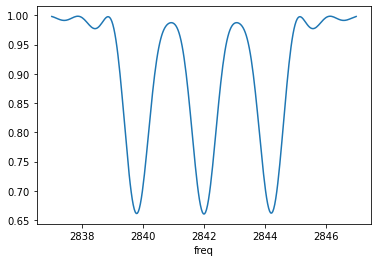

In [130]:
Azz=2.2 * 2 * np.pi #MHz
B0=1.0 #mT
bi = 2.e-3 * B0 *2 * np.pi

D = 2.87e3
bs = 28 * B0
ws = D - bs

Omega = 2 * np.pi * 0.25

time_x= 1
npoints = 500
t = np.linspace(0, time_x, npoints)

#NV operators
#electron reduced as spin 1/2
sz = q.tensor(q.sigmaz()*0.5,q.qeye(3))
sx = q.tensor(q.sigmax()*0.5,q.qeye(3))
sy = q.tensor(q.sigmay()*0.5,q.qeye(3))

#nuclear as spin 1
iz = q.tensor(q.qeye(2),q.spin_Jz(1))
ix = q.tensor(q.qeye(2),q.spin_Jx(1))
iy = q.tensor(q.qeye(2),q.spin_Jy(1))


#initialize density matrix
phi =q.basis(2,0)
rho_nv = phi*phi.dag()


#Nuclear initial pure state
rho_nuclear = q.thermal_dm(3, 1000)
rho_total = q.tensor(rho_nv,rho_nuclear)

odmr=[]

for k,Delta in enumerate(np.linspace(-5,5,300)):
    
    D = 2.87e3
    bs = 28 * B0
    ws = D - bs + Delta
    
    Delta = Delta * 2 * np.pi
    
    H = Delta * sz + Omega * sx + Azz * sz * iz + bi * iz
    
    result = q.mesolve(H=H, rho0=rho_total, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000))
    contrast = q.expect(result.states, q.tensor(q.sigmaz(),q.qeye(3)))[-1]
    freq = ws
    odmr.append([freq,contrast])
    
odmr = np.asarray(odmr).transpose()
plt.plot(odmr[0],odmr[1])
plt.xlabel('freq')

### Flip-Flop Interaction (Hartmann-Hahn)

The Hamiltonian is:\
\
$H = (\Omega + \Delta) S_x + \omega_i I_z + A_{zx} S_z I_x$,\
\
where $\Omega = \omega_i$ is equal to the Hartmann Hahn condition


#### Hartmann Hahn in Resoannce

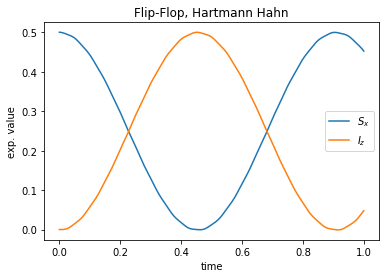

In [148]:
Azx=0.2 * 2 * np.pi #MHz
B0=1.0 #mT
bi = 10 * 2 * np.pi #MHz

Omega = 2 * np.pi * 10

time_x= 1
npoints = 500
t = np.linspace(0, time_x, npoints)

#NV operators
#electron reduced as spin 1/2
sz = q.tensor(q.sigmaz()*0.5,q.qeye(2))
sx = q.tensor(q.sigmax()*0.5,q.qeye(2))
sy = q.tensor(q.sigmay()*0.5,q.qeye(2))

#nuclear as spin 1
iz = q.tensor(q.qeye(2),q.spin_Jz(0.5))
ix = q.tensor(q.qeye(2),q.spin_Jx(0.5))
iy = q.tensor(q.qeye(2),q.spin_Jy(0.5))

#initialize density matrix
phi = (q.basis(2,0) + q.basis(2,1))/np.sqrt(2)
rho_nv = phi*phi.dag()

#Nuclear initial pure state
rho_nuclear = q.thermal_dm(2, 1000)
rho_total = q.tensor(rho_nv,rho_nuclear)

#perfect flip-flop interaction
Delta = 0
H = (Delta + Omega) * sx + Azz * sz * ix + Omega * iz

resultat = []
resultat.append(q.mesolve(H=H, rho0=rho_total, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))    

plt.title('Flip-Flop, Hartmann Hahn')
plt.plot(t,q.expect(resultat[0].states, sx),label='$S_x$')
plt.plot(t,q.expect(resultat[0].states, iz),label='$I_z$')
plt.xlabel('time')
plt.ylabel('exp. value')
plt.legend()

#### Hartmann Hahn outside of resonance

Text(0.5, 0, 'off resonance')

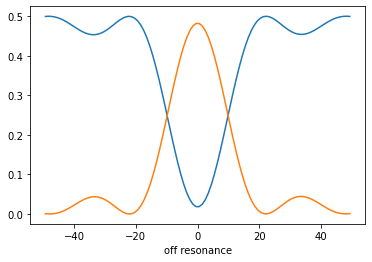

In [160]:
time_x= 0.4
npoints = 500
t = np.linspace(0, time_x, npoints)

flip_flop = []
for k,Delta in enumerate(np.linspace(-5,5,100)):
    
    Delta = Delta * 2 * np.pi
    H = (Delta + Omega) * sx + Azz * sz * ix + Omega * iz
    result= q.mesolve(H=H, rho0=rho_total, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000))
    contrast1 = q.expect(result.states, sx)[-1]
    contrast2 = q.expect(result.states, iz)[-1]
    freq = Delta / 2 * np.pi
    flip_flop.append([freq,contrast1,contrast2])
    
flip_flop = np.asarray(flip_flop).transpose()
plt.plot(flip_flop[0],flip_flop[1],label='$S_x$')
plt.plot(flip_flop[0],flip_flop[2],label='$I_z$')
plt.xlabel('off resonance')

## Time dependant solutions

### Strongly driven Rabi oscillations - non RWA

All the above is relatively simply and can be calculated analytically. But this becomes much more difficult when the rotating wave approximation (RWA) fails.
Here we look at the situation of strong driving, where $\Omega_1 \approx \omega_s$.\
$H(t) = \omega_s S_z + \Omega_1 \cos(\omega t) S_x$ \
\
In qutip the Hamiltonian is seperated in $H(t) = H_0 + H_1(t)$.

Text(0, 0.5, 'exp. value')

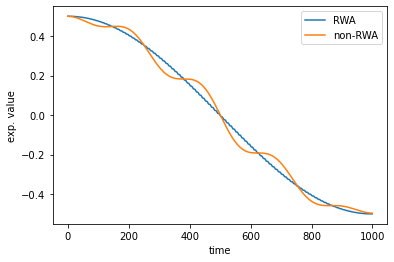

In [213]:
#Define the operators 1/2
sz = q.sigmaz() * 0.5
sx = q.sigmax() * 0.5
sy = q.sigmay() * 0.5


Omegas = [0.02,0.5]

plot_types = ['Rabi','ODMR']
plot_type = 'Rabi'

labels = ['RWA','non-RWA']
odmrs = []
for j in range(2):
    #Physical frequencies
    Omega = Omegas[j]
    Omega *= 2 * np.pi
    omegas = 1 * 2 * np.pi

    # NV hamiltonian
    H0 = omegas * sz 
    Hx1 = Omega * sx 

    def Hx1_coeff(t,args):
        delta = args['wp'] 
        phase = args['phase']
        return np.cos(1*delta * t + phase)

    H = [H0,[Hx1,Hx1_coeff]]

    #simulation parameters
    time_x=2*np.pi/Omega
    npoints = 1000
    t = np.linspace(0, time_x, npoints)

    #initial state - rho
    phi = q.basis(2,0)

    rho_nv = phi*phi.dag()
    odmr_frq = []
    odmr = []
    for k,omega in enumerate([np.pi*2]):
        wp = omega
        phase=0
        odmr_frq.append(wp/(2*np.pi))
        output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], 
                           options=q.Options(nsteps=100000), args={'wp':wp ,'phase': phase})
        odmr.append(q.expect(output.states, sz)[-1])
        
        if wp == omegas:
            plt.plot(q.expect(output.states, sz),label=labels[j])
    odmrs.append(odmr)
plt.legend()
plt.xlabel('time')
plt.ylabel('exp. value')

In [215]:
## Strongly Driven TLS - Floquet Splitting

## Non Hermitian Operation, e.g. Nitrogen T2 time

In [3]:
import qiskit
import numpy 
numpy.__version__

'1.20.1'

In [35]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

# Use Aer's qasm_simulator
simulator = QasmSimulator()

# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(1, 3)

# Add a H gate on qubit 0
circuit.h(0)

# Map the quantum measurement to the classical bits
circuit.measure(0,2)

phase = 1
circuit.rx(np.pi/2.0,0)
circuit.u1(phase,0)
circuit.rx(np.pi/2.0,0)
circuit.measure(0,1)
circuit.rx(np.pi/2.0,0)
circuit.u1(phase,0)
circuit.rx(np.pi/2.0,0)
circuit.measure(0,0)


# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit = transpile(circuit, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 00 and 11 are:",counts)

# Draw the circuit
circuit.draw()


Total count for 00 and 11 are: {'101': 316, '010': 279, '111': 31, '011': 80, '001': 89, '000': 25, '100': 90, '110': 90}


┌───┐┌─┐┌─────────┐┌───────┐┌─────────┐┌─┐┌─────────┐┌───────┐┌─────────┐»
q_0: ┤ H ├┤M├┤ RX(π/2) ├┤ U1(1) ├┤ RX(π/2) ├┤M├┤ RX(π/2) ├┤ U1(1) ├┤ RX(π/2) ├»
     └───┘└╥┘└─────────┘└───────┘└─────────┘└╥┘└─────────┘└───────┘└─────────┘»
c: 3/══════╩═════════════════════════════════╩════════════════════════════════»
           2                                 1                                »
«     ┌─┐
«q_0: ┤M├
«     └╥┘
«c: 3/═╩═
«      0

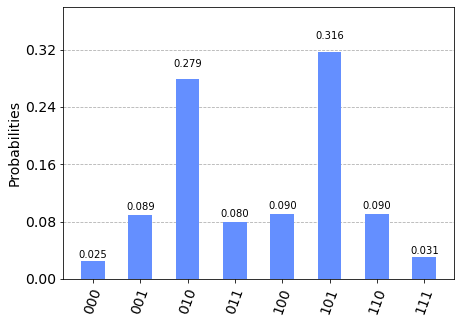

In [36]:
plot_histogram(counts)

In [37]:
import numpy 
numpy.__version__


'1.20.1'

In [73]:
def make_str_dict(counts):
    bin_dict = {}
    for key in counts.int_raw.keys():
        new_key =  "{0:b}".format(key)
        while len(new_key) != 3:
            new_key = '0' + new_key
        bin_dict[new_key]=counts.int_raw[key]
    return bin_dict

def make_flip_prob(counts):
    bin_dict = make_str_dict(counts)
    c0 = 0
    c1 = 0
    for key in bin_dict.keys():
        if key[0] != key[-1]:
            c0 += bin_dict[key]
        else:
            c1 += bin_dict[key]
    return c0 / (c1 + c0)
print(make_str_dict(counts))

make_flip_prob(counts)


{'101': 515, '010': 485}


0.0

In [74]:
## Our strage Rabis

In [75]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

# Use Aer's qasm_simulator
simulator = QasmSimulator()

# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(1, 3)

# Add a H gate on qubit 0
circuit.h(0)

# Map the quantum measurement to the classical bits
circuit.measure(0,2)

phase = np.pi
circuit.rx(phase,0)
circuit.measure(0,1)
circuit.measure(0,0)


# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit = transpile(circuit, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 00 and 11 are:",counts)

# Draw the circuit
circuit.draw()


Total count for 00 and 11 are: {'100': 516, '011': 484}


┌───┐┌─┐┌───────┐┌─┐┌─┐
q_0: ┤ H ├┤M├┤ RX(π) ├┤M├┤M├
     └───┘└╥┘└───────┘└╥┘└╥┘
c: 3/══════╩═══════════╩══╩═
           2           1  0

In [76]:

print(make_str_dict(counts))

make_flip_prob(counts)

{'100': 516, '011': 484}


1.0

In [81]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

# Use Aer's qasm_simulator
simulator = QasmSimulator()

results = {}

for phase2 in np.linspace(0,2*np.pi,100):
    # Create a Quantum Circuit acting on the q register
    circuit = QuantumCircuit(1, 3)

    # Add a H gate on qubit 0
    circuit.h(0)

    # Map the quantum measurement to the classical bits
    circuit.measure(0,2)

    phase = np.pi/2.0
    #phase2 = np.deg2rad(24)
    circuit.rx(phase,0)
    circuit.u1(phase2,0)
    circuit.rx(phase,0)
    circuit.measure(0,1)
    circuit.rx(phase,0)
    circuit.u1(phase2,0)
    circuit.rx(phase,0)

    circuit.measure(0,0)


    # compile the circuit down to low-level QASM instructions
    # supported by the backend (not needed for simple circuits)
    compiled_circuit = transpile(circuit, simulator)

    # Execute the circuit on the qasm simulator
    job = simulator.run(compiled_circuit, shots=1000)

    # Grab results from the job
    result = job.result()

    # Returns counts
    counts = result.get_counts(circuit)
    #print("\nTotal count for 00 and 11 are:",counts)
    results[phase2] = counts
    # Draw the circuit
circuit.draw()

┌───┐┌─┐┌─────────┐┌────────┐┌─────────┐┌─┐┌─────────┐┌────────┐»
q_0: ┤ H ├┤M├┤ RX(π/2) ├┤ U1(2π) ├┤ RX(π/2) ├┤M├┤ RX(π/2) ├┤ U1(2π) ├»
     └───┘└╥┘└─────────┘└────────┘└─────────┘└╥┘└─────────┘└────────┘»
c: 3/══════╩══════════════════════════════════╩══════════════════════»
           2                                  1                      »
«     ┌─────────┐┌─┐
«q_0: ┤ RX(π/2) ├┤M├
«     └─────────┘└╥┘
«c: 3/════════════╩═
«                 0

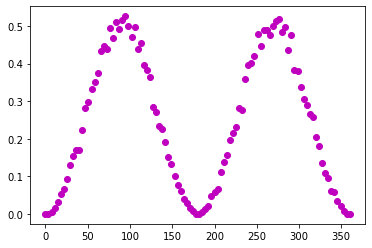

In [82]:
def plot_results(results):
    import matplotlib.pyplot as plt
    for key in results.keys():
        y = make_flip_prob(results[key])
        x = key
        plt.plot(np.rad2deg(x),y,'mo')
plot_results(results)

In [54]:
print(make_str_dict(counts))

make_flip_prob(counts)

{'101': 470, '010': 436, '100': 20, '110': 20, '001': 23, '011': 29, '000': 2}


0.908